## Notebook to test inference of saved model

In [1]:
import numpy as np
import torch
from pathlib import Path
from torch.jit import load
from PIL import Image
import matplotlib.pyplot as plt
from torch_multiwell_segmentation.tiled_prediction import TiledPrediction
import cv2
%matplotlib inline

load test sample, create tiled prediction instance

In [2]:
image_paths = list(Path("cell_culture_plate_images").glob("*.jpg"))

img0 = Image.open(image_paths[0])
img0 = np.array(img0)

# mean pooling 2times (for all channels)
img0 = img0.astype(np.float32)
img0 /= 255
img0 = (img0[::2, ::2] + img0[1::2, ::2] + img0[::2, 1::2] + img0[1::2, 1::2]) / 4



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tiled_prediction = TiledPrediction(
    tile_size=(256, 256),
    model_path="../torch_multiwell_segmentation/data/model.pt",
    overlap=(64, 64),
    device=device,
    input_channels=3,
    output_channels=2,
)





run the actual prediction

In [3]:


prediction = tiled_prediction.tile_and_apply(img0.astype(np.float32) / img0.max())
print(prediction.shape)



filter out detected well areas without cells, run a connected component analysis on the well mask.
this way we can group detected cell areas by well

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


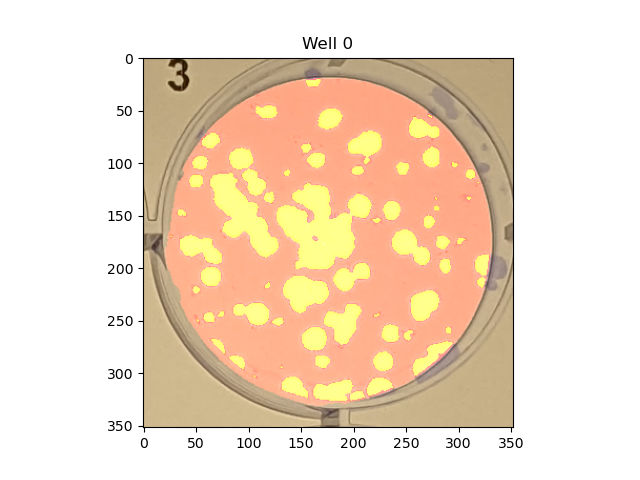

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


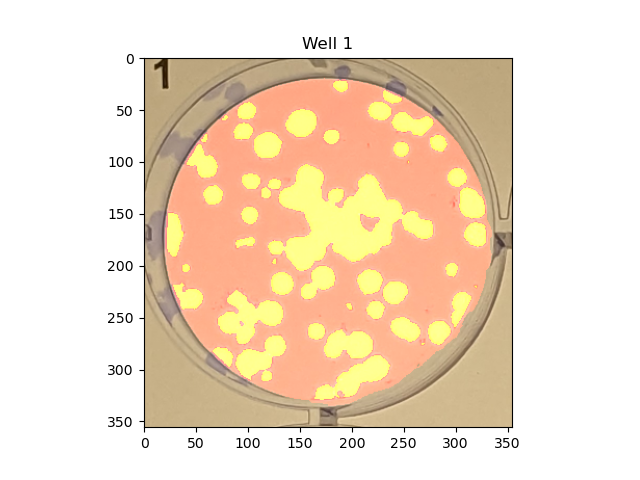

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


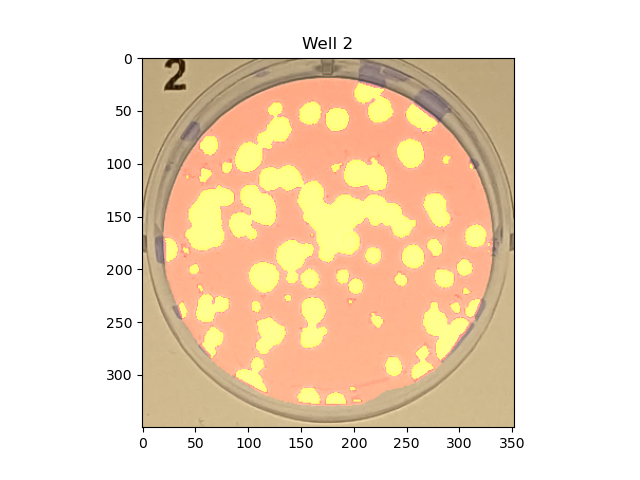

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


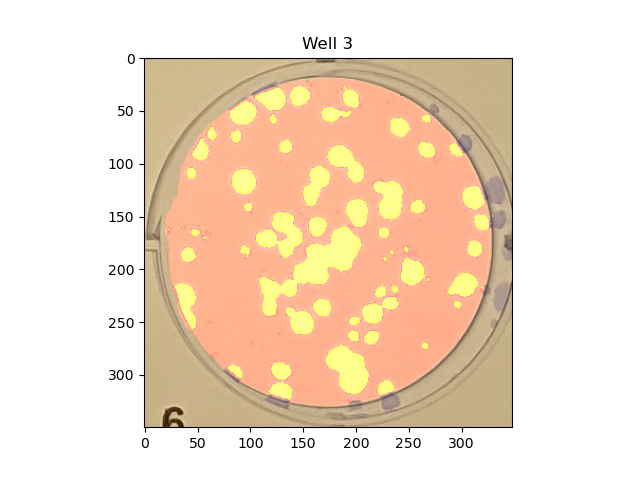

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


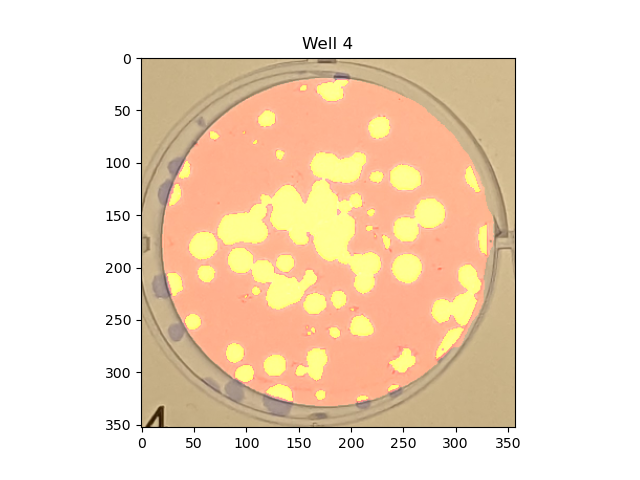

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


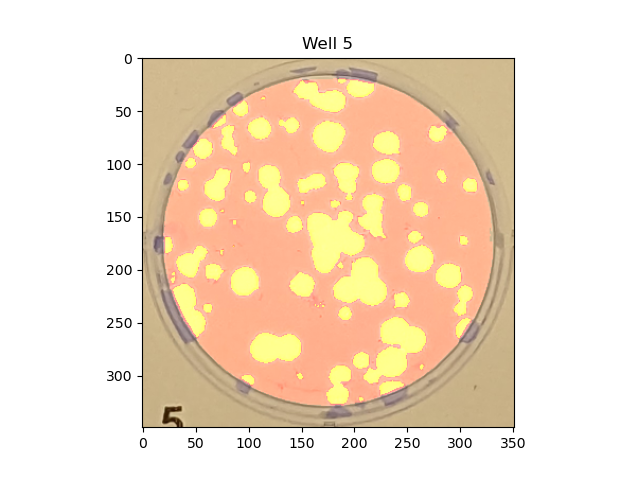

In [ ]:
well_mask = prediction[0] > 0.5
cell_mask = prediction[1] > 0.5

combined_mask = well_mask & cell_mask

# use opencv to make a connected components analysis on the well_mask

# find the connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
    well_mask.astype(np.uint8)
)

# only keep well labels that have at least one pixel in the cell mask and are not the background
well_labels = np.unique(labels[cell_mask & (labels != 0)])

# create a new mask with only the well labels
well_mask = np.isin(labels, well_labels)

# remove the background label
well_mask[labels == 0] = False

# for each remaining well mask, determine it's extent and plot the cropped image with well_mask and cell_mask overlay

for i, well in enumerate(np.unique(labels[well_mask])):
    # get the bounding box for the well
    x, y, w, h, area = stats[well]
    
    # add a small buffer
    buffer = 20
    x -= buffer
    y -= buffer
    w += buffer * 2
    h += buffer * 2


    if x < 0:
        x = 0
    if y < 0:
        y = 0
    if x + w > img0.shape[1]:
        w = img0.shape[1] - x
    if y + h > img0.shape[0]:
        h = img0.shape[0] - y
    

    # crop the well mask and cell mask
    well_mask_crop = well_mask[y : y + h, x : x + w]
    cell_mask_crop = cell_mask[y : y + h, x : x + w]
    # create a combined mask
    combined_mask_crop = well_mask_crop & cell_mask_crop
    # create a new image with the well mask overlay
    img_crop = img0[y : y + h, x : x + w].copy()
    img_crop[well_mask_crop,0] = 255
    img_crop[cell_mask_crop,1] = 255

    # plot the image
    plt.figure()
    plt.imshow(img_crop)
    plt.title(f"Well {i}")
    plt.show() 
